## Import

In [89]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

## Read dataset

In [90]:
dataset = pd.read_csv('datasets/DailyDelhiClimateTrain.csv')
dataset

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


## Count of duplicate and NaN values

In [91]:
dup = dataset.duplicated().sum()
print('Any Duplicate Value:',dup)
dataset.isnull().sum()

Any Duplicate Value: 0


date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [92]:
df_test = pd.read_csv('datasets/DailyDelhiClimateTrain.csv')

In [93]:

row = df_test["wind_speed"]
training_time_steps = 1000

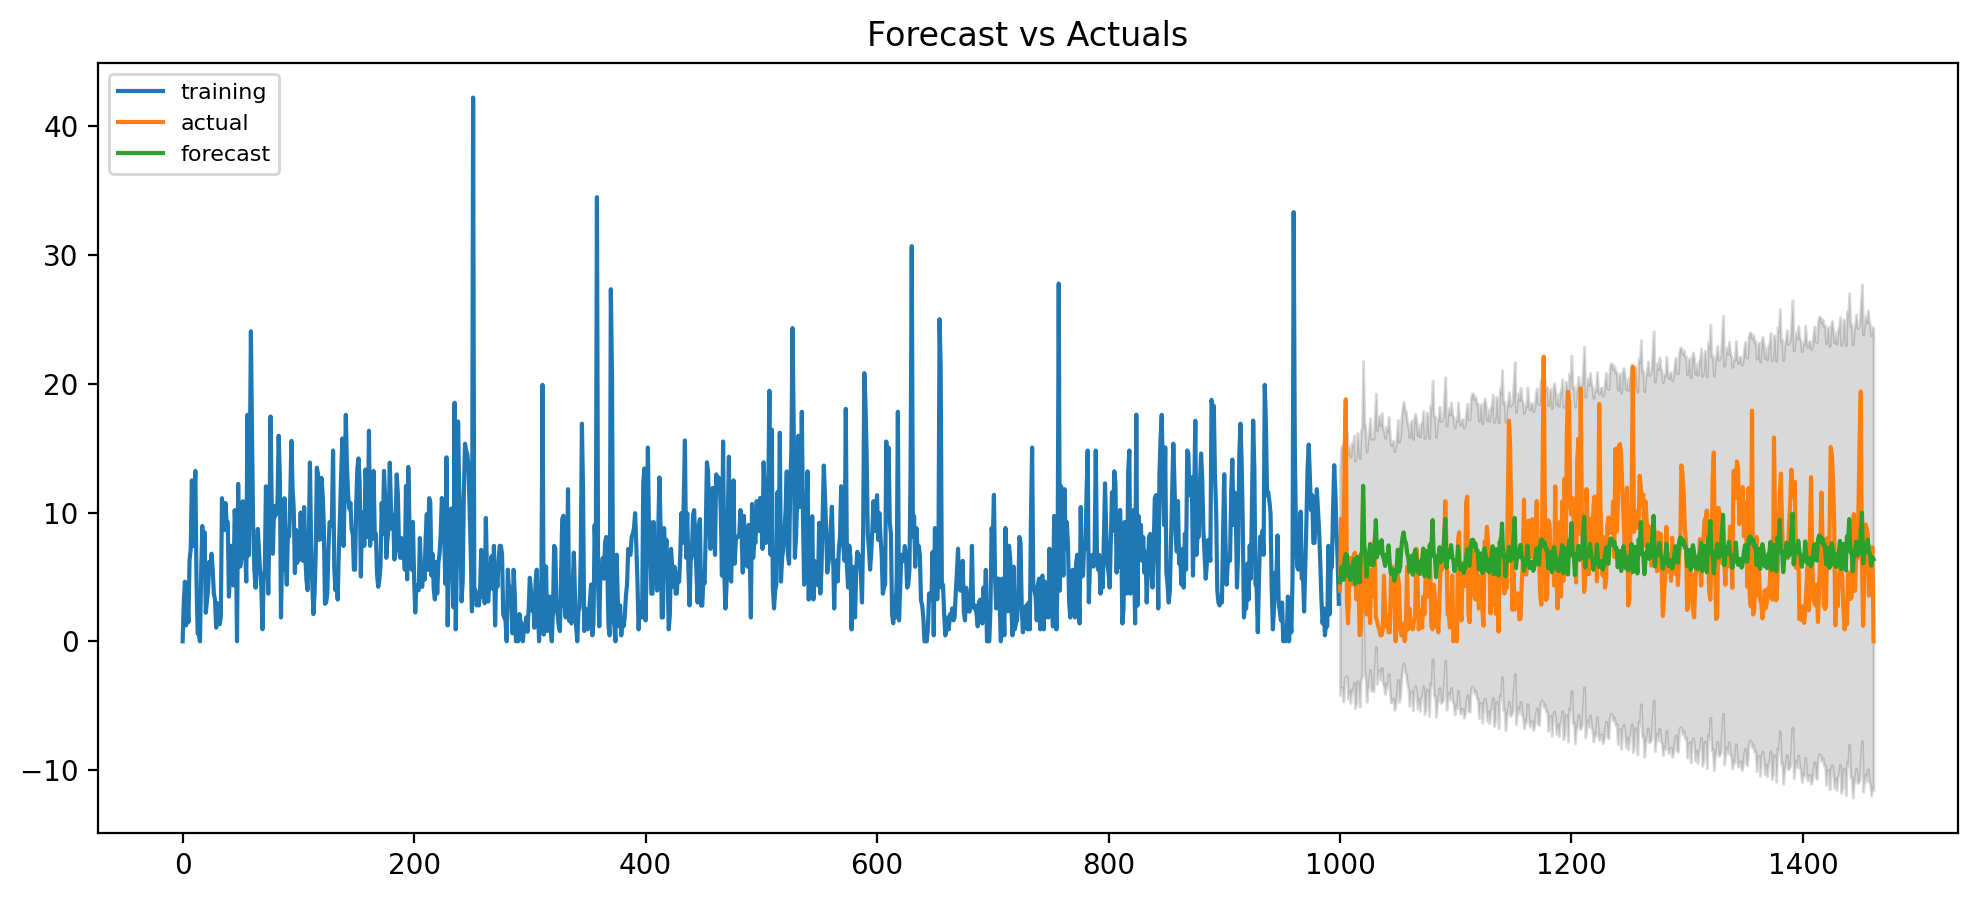

In [94]:
model = ARIMA(row[:training_time_steps], order=(1, 1, 1), seasonal_order=(1,1,1,60))
fitted = model.fit()

fc = fitted.get_forecast(len(row[training_time_steps:]))
conf = fc.conf_int(alpha=0.05) 

fc_series = pd.Series(fc.predicted_mean, index=row[training_time_steps:].index)
lower_series = pd.Series(conf.iloc[:, 0], index=row[training_time_steps:].index)
upper_series = pd.Series(conf.iloc[:, 1], index=row[training_time_steps:].index)


plt.figure(figsize=(12,5), dpi=200)
plt.plot(row[:training_time_steps], label='training')
plt.plot(row[training_time_steps:], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [95]:
sequence_length = 30
X = []
y = []
time_steps = len(row)
for i in range(time_steps - sequence_length):
    sequence = row[i:(i+sequence_length)]
    X.append(sequence)
    y.append(row[i+sequence_length])
X = np.array(X)
y = np.array(y)

In [96]:
time_steps = len(X)
training_time_steps = math.floor(time_steps * 0.7)
X_train = X[:training_time_steps]
X_test = X[training_time_steps:]
y_train = y[:training_time_steps]
y_test = y[training_time_steps:]

X_train_sequences = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_sequences = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_anth = X.reshape(X.shape[0], 1, X.shape[1])

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses, metrics, optimizers

regressor = Sequential([layers.LSTM(units = 32, activation = 'relu', input_shape = (1, sequence_length)), layers.Dense(1)])

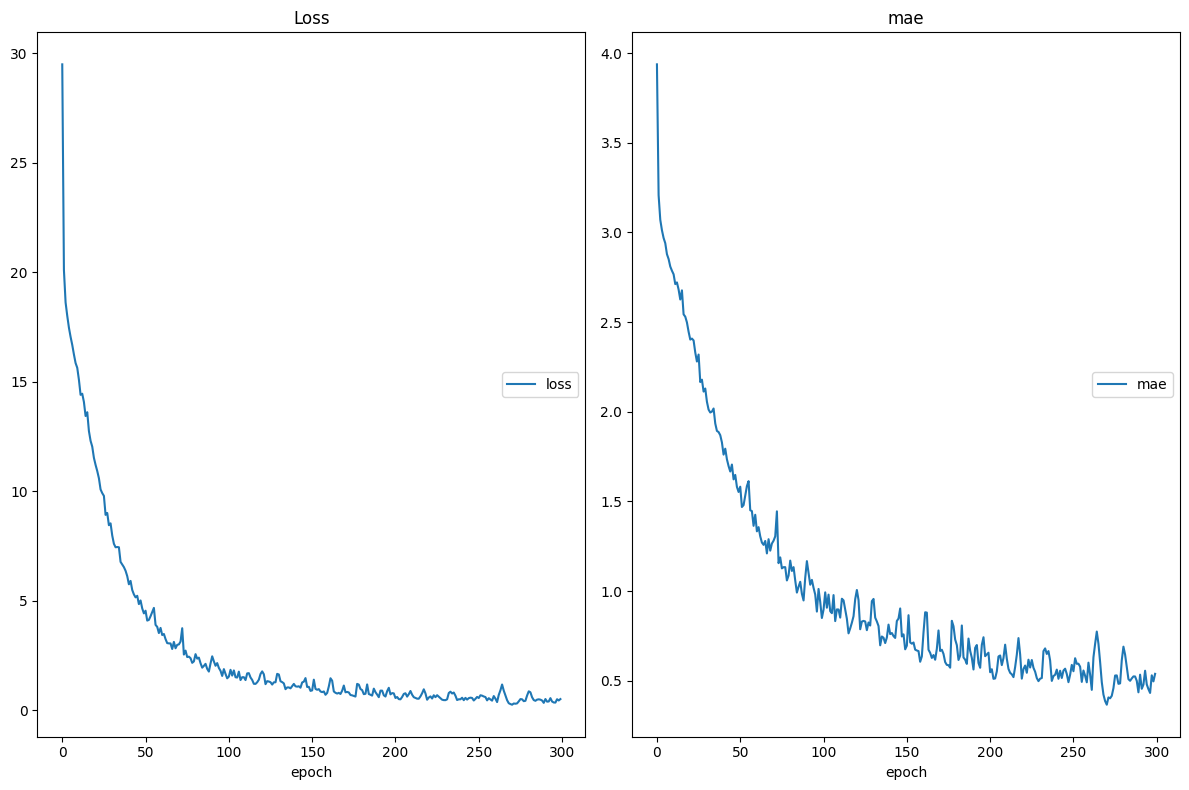

Loss
	loss             	 (min:    0.263, max:   29.500, cur:    0.520)
mae
	mae              	 (min:    0.366, max:    3.937, cur:    0.538)


In [98]:
from livelossplot import PlotLossesKerasTF
regressor.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
history = regressor.fit(X_train_sequences, y_train, batch_size=10, epochs=300, verbose=0, callbacks=[PlotLossesKerasTF()])

In [99]:
y_predicted = regressor.predict(X_test_sequences)

14/14 [==============================] - 0s 844us/step


In [100]:
training_sequences = training_time_steps

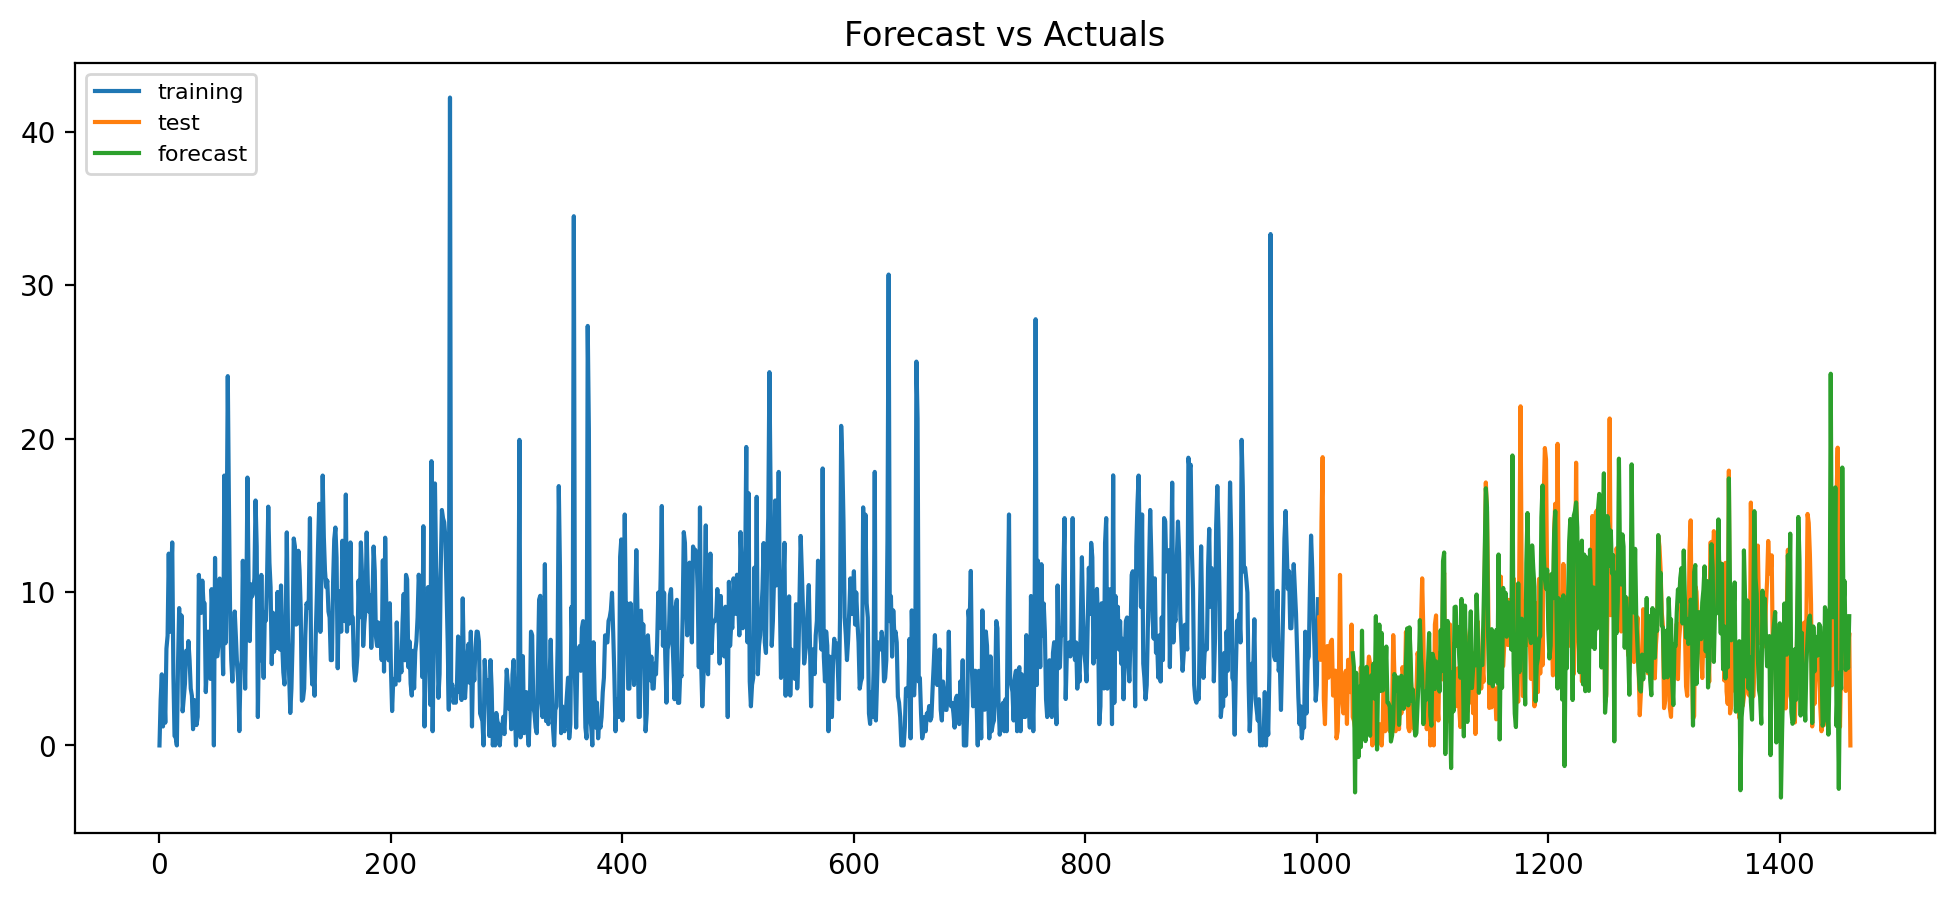

In [101]:
plt.figure(figsize=(12,5), dpi=200)
plt.plot(range(training_sequences), row[:training_sequences], label='training')
plt.plot(range(training_sequences, len(row)), row[training_sequences:], label='test')
plt.plot(range(1031,1461), y_predicted, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()